### Fine-tune the pre-trained FaceNet model towards the Caltech Face Dataset (450 images, 30 peaple) using triplet loss function

In [9]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout
from keras.layers import Input
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler



In [2]:
from utils.FaceNet_utils import one_hot, distance_based_prediction, evaluate_model, face_dist, load_FaceData, load_base_model

In [3]:
nFace = 450

In [4]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)

    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)

    Returns:
    loss -- real number, value of the loss
    """

    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]

    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = K.sum(K.maximum(basic_loss,0.0))
    ### END CODE HERE ###

    return loss

In [5]:
def Create_Siamese_model(basemodel,alpha = 0.2):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    Anchor_Input    = Input(basemodel_input_shape)
    Positive_Input  = Input(basemodel_input_shape)
    Negative_Input  = Input(basemodel_input_shape)
    
    Anchor_Predict   = basemodel(Anchor_Input)
    Positive_Predict = basemodel(Positive_Input)
    Negative_Predict = basemodel(Negative_Input)
    
    pos_dist = K.sum(K.square(Anchor_Predict-Positive_Predict),axis=-1)
    neg_dist = K.sum(K.square(Anchor_Predict-Negative_Predict),axis=-1)
    print(pos_dist)
    print(neg_dist)
    basic_loss = pos_dist - neg_dist + alpha
    print(basic_loss)
    loss = K.maximum(basic_loss,0.0)
    print(loss)

    SiameseModel = Model(inputs = [Anchor_Input, Positive_Input, Negative_Input], outputs = loss)
    
    return SiameseModel 

In [6]:
FNModel = load_base_model()

In [7]:
FNModel.count_params()

3743280

In [10]:
FaceData, labels, labels_OH = load_FaceData(nFace)
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)

(450, 3, 96, 96)
(450,)
(450, 31)


In [11]:
nPeople = labels_OH.shape[1]

In [12]:
FaceEmbedding = FNModel.predict(FaceData)

In [13]:
pca = decomposition.PCA(n_components = 2)

In [14]:
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)

Text(0.5,1,'feature space')

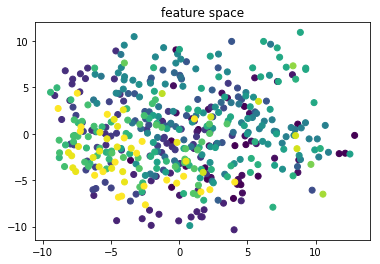

In [15]:
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.title('feature space')

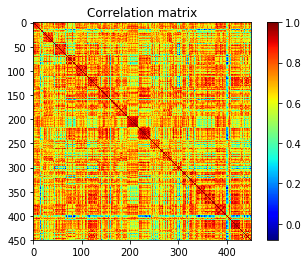

In [16]:
FaceEmbedding_Corr = np.corrcoef(FaceEmbedding)
plt.imshow(FaceEmbedding_Corr,cmap='jet')
plt.title('Correlation matrix')
plt.colorbar()

In [15]:
Distances_within_class = []
Distances_among_class = []

FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]==labels[j]:
            Distances_within_class.append(FaceEmbedding_Dist[i,j])
        else:
            Distances_among_class.append(FaceEmbedding_Dist[i,j])
            
Distances_within_class = np.array(Distances_within_class)
Distances_among_class = np.array(Distances_among_class)

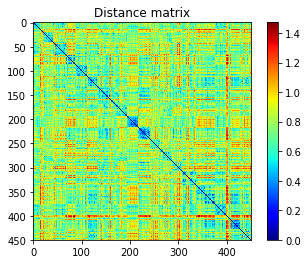

In [16]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.805 +\- 0.168
Same-class distance = 0.519 +\- 0.232


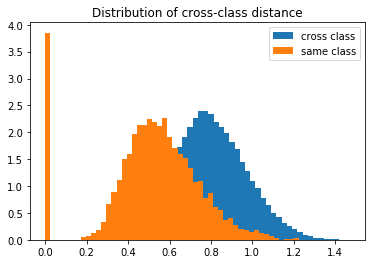

In [17]:
plt.figure()
_ = plt.hist(Distances_among_class,bins = 50, label = 'cross class',normed = True)
_ = plt.hist(Distances_within_class,bins = 50, label = 'same class', normed = True)
plt.title('Distribution of cross-class distance')
plt.legend()

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_among_class.mean(), Distances_among_class.std()))
print('Same-class distance = %1.3f +\- %1.3f' % (Distances_within_class.mean(), Distances_within_class.std()))

### Note:
Even before doing anything, the direct embedding of faces using FaceNet is already able to recognize faces at decent level.

pct of false positive 23.812 %
pct of false negative 22.103 %
accuracy = 76.268


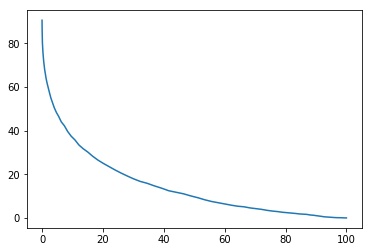

In [18]:
FP = []
FN = []

for threshold in np.arange(0,max(Distances_among_class),0.01):
    FP.append(100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class))
    FN.append(100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class))
    
plt.plot(FP,FN)  
threshold = 0.68
print('pct of false positive %2.3f %%' % (100.0*np.sum(Distances_among_class<threshold)/len(Distances_among_class)))
print('pct of false negative %2.3f %%' % (100.0*np.sum(Distances_within_class>threshold)/len(Distances_within_class)))

print('accuracy = %2.3f' % (100.0*(np.sum(Distances_among_class>threshold)+np.sum(Distances_within_class<threshold))/(len(Distances_among_class)+len(Distances_within_class))))

In [19]:
train_idx = []
test_idx = []
for l in set(labels):
    ind = np.where(labels==l)[0]
    if len(ind)<=1:
        ind_train = list(ind)
        ind_test = []
    else:
        i_split = max([3,int(len(ind)*0.7)])
        ind_train = list(ind[0:i_split])
        ind_test = list(ind[i_split:])
    train_idx += ind_train
    test_idx += ind_test  
print("Training data set has %d face images", len(train_idx))
print("Test data set has %d face images", len(test_idx))

Training data set has %d face images 307
Test data set has %d face images 143


In [20]:
nCorrect = 0
for i in test_idx:
    p = distance_based_prediction(FaceEmbedding[train_idx], labels[train_idx], FaceEmbedding[i])
    if p == labels[i]:
        nCorrect += 1
print('Face recognition accuracy using purely distance based method: %3.3f %%' % (100.*(0.+nCorrect)/len(test_idx)))

Face recognition accuracy using purely distance based method: 74.126 %


## Generate Anchor, positive and negative combinations to train Siamese model built on top of the FaceNet model

In [60]:
SiameseModel = Create_Siamese_model(FNModel)

Tensor("Sum_4:0", shape=(?,), dtype=float32)
Tensor("Sum_5:0", shape=(?,), dtype=float32)
Tensor("add_1:0", shape=(?,), dtype=float32)
Tensor("Maximum_1:0", shape=(?,), dtype=float32)


TypeError: Output tensors to a Model must be Keras tensors. Found: Tensor("Maximum_1:0", shape=(?,), dtype=float32)

In [24]:
SiameseModel.output

[<tf.Tensor 'FaceRecoModel/lambda_2/l2_normalize:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'FaceRecoModel_1/lambda_2/l2_normalize:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'FaceRecoModel_2/lambda_2/l2_normalize:0' shape=(?, 128) dtype=float32>]

In [25]:
SiameseModel.compile(optimizer = 'adam', loss = triplet_loss)

In [26]:
nFace

450

In [48]:
#find hard to train positive and negative combinations
A = []
P = []
N = []

dist_threshold = 0.4
for i in range(nPeople):
    ifaces = np.where(labels==i)[0]

    iOtherPerson = list(set(range(nFace))-set(ifaces))
    
    for iface in ifaces:
        iSamePerson = list(ifaces)
        
        #find negative faces
        nNegativeFaces = (FaceEmbedding_Dist[iface,iOtherPerson]<dist_threshold).sum()
        #nNegativeFaces = max(2,nNegativeFaces)
        if nNegativeFaces == 0:
            continue
        
        iNegativeFaces = FaceEmbedding_Dist[iface,iOtherPerson].argsort()[:nNegativeFaces]
        iNegativeFaces = np.array(iOtherPerson)[iNegativeFaces]
        
        DistNegativeFaces = FaceEmbedding_Dist[iface,list(iNegativeFaces)]
        probNegativeFaces = DistNegativeFaces.max() - DistNegativeFaces + 0.1
        probNegativeFaces = probNegativeFaces/probNegativeFaces.sum()
        
        #find positive faces
        nPositiveFaces = (FaceEmbedding_Dist[iface,iSamePerson]>dist_threshold).sum()
        nPositiveFaces = max(1,nPositiveFaces)
        
        iPositiveFaces = FaceEmbedding_Dist[iface,iSamePerson].argsort()[-nPositiveFaces:]
        iPositiveFaces = np.array(iSamePerson)[iPositiveFaces]
        
        DistPositiveFaces = FaceEmbedding_Dist[iface,list(iPositiveFaces)]
        probPositiveFaces = DistPositiveFaces.max() - DistPositiveFaces + 0.1
        probPositiveFaces = probPositiveFaces/probPositiveFaces.sum()
        
        #samples
        nTotalSample = nNegativeFaces*nPositiveFaces+1
        
        iNegative = np.random.choice(nNegativeFaces,nTotalSample, p = probNegativeFaces)
        iNegative = iNegativeFaces[iNegative]
        iPositive = np.random.choice(nPositiveFaces,nTotalSample, p = probPositiveFaces)
        iPositive = iPositiveFaces[iPositive]

        iAnchor = np.ones((nTotalSample,),dtype=int)*iface
    
        A += list(iAnchor)
        P += list(iPositive)
        N += list(iNegative)

In [49]:
nAPN = len(A)
print('%d number of A, P, N combinations had been identified' % nAPN)

6331 number of A, P, N combinations had been identified


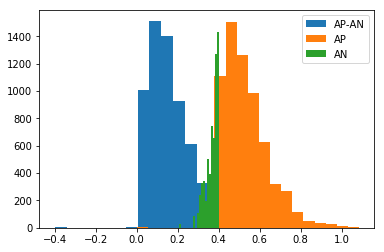

APN = 0.169 +\- 0.114
AP = 0.533 +\- 0.109
AN = 0.365 +\- 0.031


In [50]:
APN, AP, AN = [], [] ,[]
for i, iA in enumerate(A):
    iP, iN = P[i], N[i]
    Dist_AP = FaceEmbedding_Dist[iA,iP]
    Dist_AN = FaceEmbedding_Dist[iA,iN]
    APN.append(Dist_AP-Dist_AN)
    AP.append(Dist_AP)
    AN.append(Dist_AN)

plt.hist(APN,bins=20,label='AP-AN')
plt.hist(AP, bins=20,label='AP')
plt.hist(AN, bins=20,label='AN')
plt.legend()
plt.show()

print('APN = %1.3f +\- %1.3f' % (np.array(APN).mean(), np.array(APN).std()))
print('AP = %1.3f +\- %1.3f' % (np.array(AP).mean(), np.array(AP).std()))
print('AN = %1.3f +\- %1.3f' % (np.array(AN).mean(), np.array(AN).std()))

In [51]:
Ytrue = np.ones((nAPN,128))

In [52]:
#SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
SiameseModel.fit([FaceData[A],FaceData[P],FaceData[N]], [Ytrue,Ytrue,Ytrue], epochs = 1)

Epoch 1/1
2592/6331 [===========>..................] - ETA: 25:35 - loss: 0.6180 - FaceRecoModel_loss: 0.2099

KeyboardInterrupt: 

Epoch 1/5
5/5 [==============================] - 2s 406ms/step - loss: 1.3302 - FaceRecoModel_loss: 0.2000
Epoch 2/5
5/5 [==============================] - 2s 415ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 3/5
5/5 [==============================] - 2s 397ms/step - loss: 2.0841 - FaceRecoModel_loss: 0.2000
Epoch 4/5
5/5 [==============================] - 2s 399ms/step - loss: 3.0935 - FaceRecoModel_loss: 2.8935
Epoch 5/5
5/5 [==============================] - 2s 399ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000


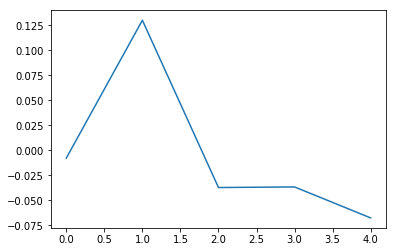

Epoch 1/5
5/5 [==============================] - 2s 429ms/step - loss: 1.2943 - FaceRecoModel_loss: 0.0000e+00
Epoch 2/5
5/5 [==============================] - 2s 421ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 3/5
5/5 [==============================] - 2s 401ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 4/5
5/5 [==============================] - 2s 398ms/step - loss: 0.2000 - FaceRecoModel_loss: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 2s 400ms/step - loss: 0.2000 - FaceRecoModel_loss: 0.0000e+00


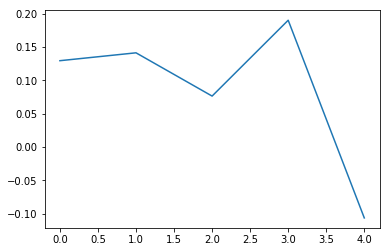

Epoch 1/5
5/5 [==============================] - 2s 424ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 2/5
5/5 [==============================] - 2s 401ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 3/5
5/5 [==============================] - 2s 403ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 4/5
5/5 [==============================] - 2s 425ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.0000e+00
Epoch 5/5
5/5 [==============================] - 2s 399ms/step - loss: 0.9323 - FaceRecoModel_loss: 0.2000


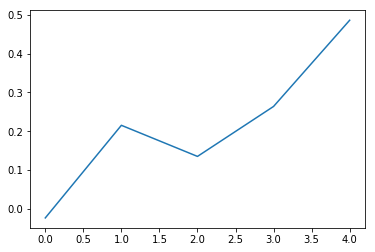

Epoch 1/5
5/5 [==============================] - 2s 426ms/step - loss: 1.9063 - FaceRecoModel_loss: 1.7063
Epoch 2/5
5/5 [==============================] - 2s 439ms/step - loss: 1.7634 - FaceRecoModel_loss: 1.3634
Epoch 3/5
5/5 [==============================] - 2s 399ms/step - loss: 2.1357 - FaceRecoModel_loss: 0.2000
Epoch 4/5
5/5 [==============================] - 2s 467ms/step - loss: 1.3969 - FaceRecoModel_loss: 0.7360
Epoch 5/5
5/5 [==============================] - 2s 497ms/step - loss: 1.0454 - FaceRecoModel_loss: 0.5259


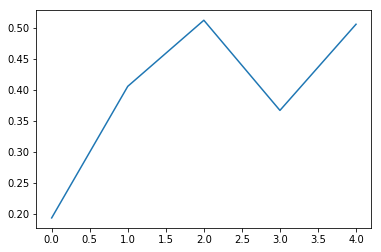

Epoch 1/5
5/5 [==============================] - 2s 422ms/step - loss: 0.8492 - FaceRecoModel_loss: 0.3795
Epoch 2/5
5/5 [==============================] - 2s 431ms/step - loss: 0.5065 - FaceRecoModel_loss: 0.3065
Epoch 3/5
5/5 [==============================] - 2s 431ms/step - loss: 0.5311 - FaceRecoModel_loss: 0.1311
Epoch 4/5
5/5 [==============================] - 2s 433ms/step - loss: 0.4000 - FaceRecoModel_loss: 0.2000
Epoch 5/5
5/5 [==============================] - 2s 451ms/step - loss: 0.4978 - FaceRecoModel_loss: 0.0978


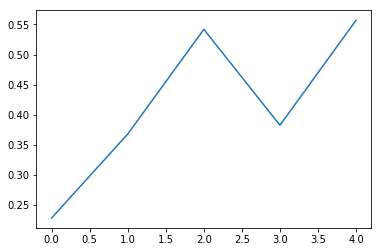

In [46]:
for i in range(5):
    SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], [np.ones((5,128)),np.ones((5,128)),np.ones((5,128))], epochs = 5)
    
    tmp = SiameseModel.predict([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]])
    Dist_AP = face_dist(tmp[0],tmp[1])
    Dist_AN = face_dist(tmp[0],tmp[2])
    plt.figure()
    plt.plot(Dist_AP-Dist_AN)
    plt.show()

In [ ]:
evaluate_model(myModel, FaceEmbedding[train_idx], labels_OH[train_idx], FaceEmbedding[test_idx], labels_OH[test_idx], maxItem = 1000)

In [ ]:
for j in test_idx:
    p=np.argmax(myModel.predict(FaceEmbedding[j:j+1,:]))
    if p!=labels[j]:
        plt.figure()
        plt.imshow(FaceData[j].transpose((1,2,0)))
        plt.title('pred %d, true %d' % (p,labels[j]))
        plt.show()
        plt.figure()
        tmp = np.where(labels==p)[0][0]
        plt.imshow(FaceData[tmp].transpose((1,2,0)))
        plt.show()

In [ ]:
FaceEmbedding.shape